In [125]:
from os import listdir
from os.path import isfile, join
#Para ver las palabras
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords #Listas de stopwords
from nltk.tokenize import word_tokenize #Tokens
import re #regex

In [126]:
def get_txt(path):
    """
    Regresa una lista con el contenido de todos los archivos de un directorio

    Args:
        path (str): ruta de la carpeta
    """
    text = []
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    
    for file in onlyfiles:
         with open(path+"/"+file, 'rb') as f:
            text.append(f.read().decode('utf-8', 'replace'))
    return text

movies = {}
movies["Pride & Prejudice"] = get_txt("../corpus/Pride & Prejudice")
movies["Marvel"] = get_txt("../corpus/Marvel")
movies["Christopher Nolan"] = get_txt("../corpus/Christopher Nolan")

In [127]:
def show_words(word):
    mycloud = WordCloud()
    mycloud.generate_from_frequencies(Counter(word))

    plt.figure(figsize=(8,6), dpi=120)
    plt.imshow(mycloud)
    plt.axis("off")
    plt.show()

In [128]:
def get_word(name):
    corpus = []
    for i, movie in enumerate(movies[name]):
        movies[name][i] = word_tokenize(movie)
        corpus += movies[name][i]
    return corpus

marvel = get_word("Marvel")
nolan = get_word("Christopher Nolan")
pride = get_word("Pride & Prejudice")

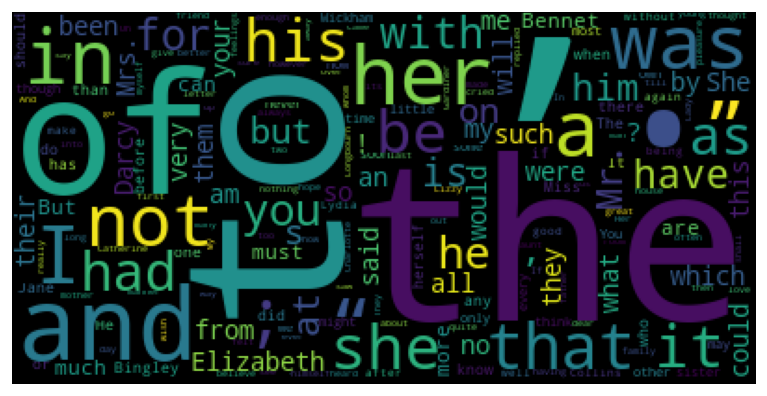

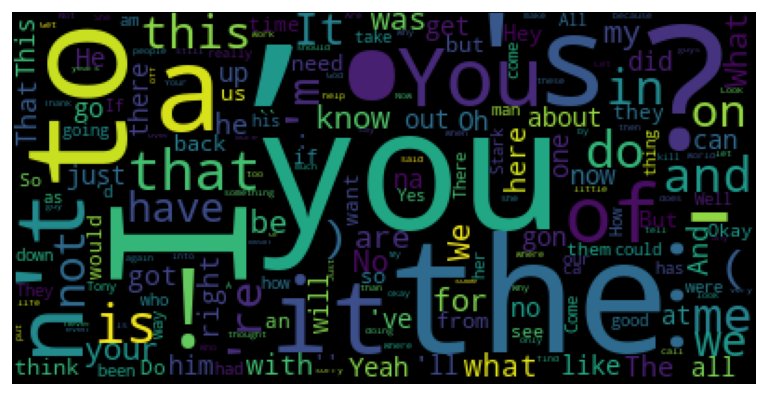

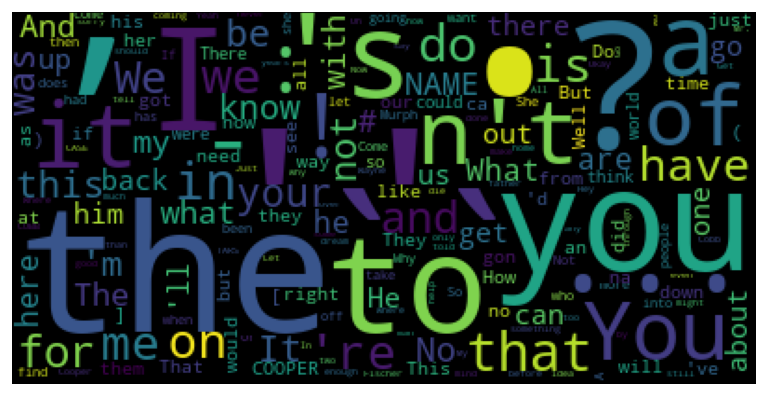

In [129]:
#Gráfica de palabras para la peli (texto sucio)
show_words(pride) #dividir por palabras
show_words(marvel)
show_words(nolan)

In [130]:
num = len(pride) + len(marvel) + len(nolan)
print("Número de tokens antes de limpiar el texto: ", num)
num = len(set(pride + marvel + nolan))
print("Número de tokens no repetidos (tipos): ", num)

Número de tokens antes de limpiar el texto:  500473
Número de tokens no repetidos (tipos):  20406


In [131]:
more = ["'ve", "'ll", "'t", "'s", "'re", "'", "'m", "'d", "n't", "oh", "hey", "yeah","okay", "mr.", "miss", "mrs."]
stopwords_list = stopwords.words('english') + more

def clean_corpus(corpus):
    clean = []
    pattern = r'[^a-z0-9\s]'
    for w in corpus:
        #quita stopwords y convierte a minúsculas
        if w.lower() not in stopwords_list and re.sub(pattern,'', w) != '':
            if  w == "na": #Para juntar gon na, wan na, etc.
                clean[-1] += w
            else:
                clean.append(w)
    return clean

movies["Pride & Prejudice"] = clean_corpus(movies["Pride & Prejudice"][0])
movies["Marvel"] = [clean_corpus(m) for m in movies["Marvel"]]
movies["Christopher Nolan"] = [clean_corpus(m) for m in movies["Christopher Nolan"]]

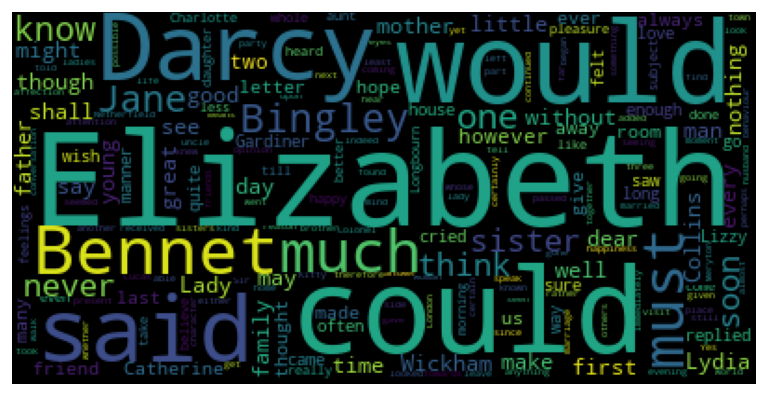

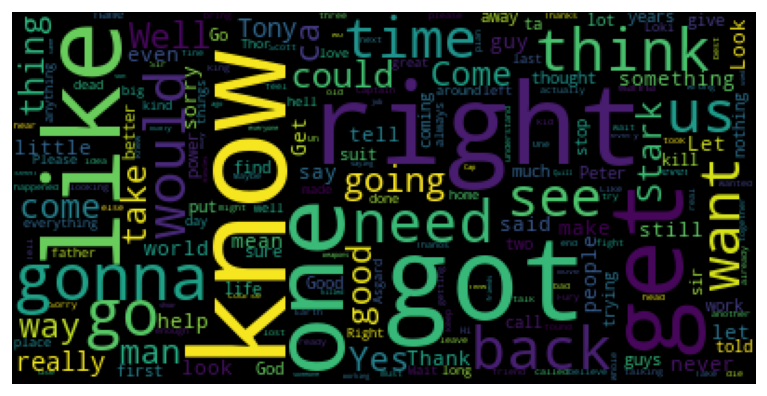

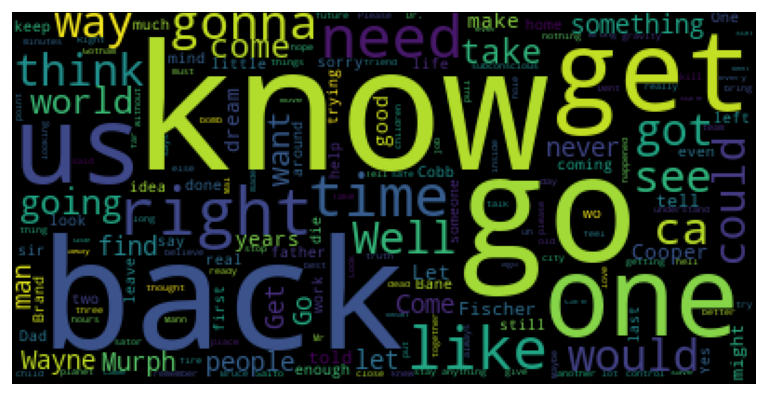

In [132]:
def merge_movies(name):
    corpus = []
    for movie in movies[name]:
        corpus += movie
    return corpus
    
show_words(movies["Pride & Prejudice"])
show_words(merge_movies("Marvel"))
show_words(merge_movies("Christopher Nolan"))

# Algoritmo BPE

In [ ]:
def get_stats(words):
    stats = {}
    for word, freq in words.item():
        chars = word.split()

        for i in range(len(chars)-1):
            aux = (chars[i], chars[1+i])
            stats[aux] = freq if aux not in stats else stats[aux] + freq

    return stats


def merge_frequent(pair, voc_in):
    # vocabulario de salida
    voc_out = {}
    # escapa el patron de mayor frecuencia
    bigram = escape(' '.join(pair))
    # regex para buscar dentro de la palabra
    pattern = compile(r'(?<!\S)' + bigram + r'(?!\S)')

    for word in voc_in:
        #(a, b) -> 'ab'
        w_out = pattern.sub(''.join(pair), word)
        # define un nuevo vocabulario con el nuevo simbolo ab
        voc_out[w_out] = voc_in[word]
    
    return voc_out
        

def BPE(epoch, words):
    new_words = words
    for i in range(epoch):
        #Obtiene pares y frecuencias
        pair = get_stats(new_words)
        try:
            #Símbolo de mayor frecuencia
            best = max(pair, key=pair.get)
            new_words = merge_frequent(best, new_words)
        except:
            break
    return new_words